In [1]:
# import PyCall
import PyPlot
plt = PyPlot

include("controls.jl")

dampen_alt_policy (generic function with 1 method)

In [2]:
mutable struct PhysicalParameters
    # Motor
    Rm::Float64  # Resistance
    kt::Float64  # Current-torque (N-m/A)
    km::Float64  # Back-emf constant (V-s/rad)

    # Rotary Arm
    mr::Float64  # Mass (kg)
    Lr::Float64  # Total length (m)
    Jr::Float64  # Moment of inertia about pivot (kg-m^2)
    Dr::Float64  # Equivalent viscous damping coefficient (N-m-s/rad)

    # Pendulum Link
    mp::Float64  # Mass (kg)
    Lp::Float64  # Total length (m)
    Jp::Float64  # Moment of inertia about pivot (kg-m^2)
    Dp::Float64  # Equivalent viscous damping coefficient (N-m-s/rad)

    g::Float64  # Gravity constant

    function PhysicalParameters()
        Rm = 8.4
        kt = 0.042
        km = 0.042
        mr = 0.095
        Lr = 0.085
        Jr = mr * Lr ^ 2 / 12
        Dr = 0.00027
        mp = 0.024
        Lp = 0.129
        Jp = mp * Lp ^ 2 / 12
        Dp = 0.00005
        g = 9.81
        new(Rm, kt, km, mr, Lr, Jr, Dr, mp, Lp, Jp, Dp, g)
    end
end

In [28]:
function forward_model_euler(
    θ::Float64, α::Float64, θ̇::Float64, α̇::Float64,
    Vm::Float64,
    dt::Float64,
    p::PhysicalParameters,
    integration_steps::Int
)
    dt /= integration_steps
    for step in range(1, length=integration_steps)
        tau = -(p.km * (Vm - p.km * θ̇)) / p.Rm  # torque

        # From Rotary Pendulum Workbook
        θ̈::Float64 = (-p.Lp*p.Lr*p.mp*(-8.0*p.Dp*α̇ + p.Lp^2*p.mp*θ̇^2*sin(2.0*α) + 4.0*p.Lp*p.g*p.mp*sin(α))*cos(α) + (4.0*p.Jp + p.Lp^2*p.mp)*(4.0*p.Dr*θ̇ + p.Lp^2*α̇*p.mp*θ̇*sin(2.0*α) + 2.0*p.Lp*p.Lr*α̇^2*p.mp*sin(α) - 4.0*tau))/(4.0*p.Lp^2*p.Lr^2*p.mp^2*cos(α)^2 - (4.0*p.Jp + p.Lp^2*p.mp)*(4.0*p.Jr + p.Lp^2*p.mp*sin(α)^2 + 4.0*p.Lr^2*p.mp))
        α̈::Float64 = (2.0*p.Lp*p.Lr*p.mp*(4.0*p.Dr*θ̇ + p.Lp^2*α̇*p.mp*θ̇*sin(2.0*α) + 2.0*p.Lp*p.Lr*α̇^2*p.mp*sin(α) - 4.0*tau)*cos(α) - 0.5*(4.0*p.Jr + p.Lp^2*p.mp*sin(α)^2 + 4.0*p.Lr^2*p.mp)*(-8.0*p.Dp*α̇ + p.Lp^2*p.mp*θ̇^2*sin(2.0*α) + 4.0*p.Lp*p.g*p.mp*sin(α)))/(4.0*p.Lp^2*p.Lr^2*p.mp^2*cos(α)^2 - (4.0*p.Jp + p.Lp^2*p.mp)*(4.0*p.Jr + p.Lp^2*p.mp*sin(α)^2 + 4.0*p.Lr^2*p.mp))

        θ̇ += θ̈ * dt
        α̇ += α̈ * dt

        θ += θ̇ * dt
        α += α̇ * dt

        θ = rem2pi(θ, RoundNearest)
        α = rem2pi(α, RoundNearest)
    end

    θ, α, θ̇, α̇
end

forward_model_euler (generic function with 1 method)

In [29]:
function plot_results(hists, labels, colors=Nothing)
    state_dims = ["Theta", "Alpha", "Theta dot", "Alpha dot"]
    n_axes = length(state_dims)
    
    f, fig_axes = plt.subplots(n_axes, 1, sharex=true)
    for (i, ax) in enumerate(fig_axes)
        if colors == Nothing
            for (hist, label) in zip(hists, labels)
                ax.plot(hist[:,i], label=label)
            end
        else
            for (hist, label, color) in zip(hists, labels, colors)
                ax.plot(hist[:,i], label=label, color=color)
            end
        end
        ax.set_ylabel(state_dims[i])
        ax.legend()
    end
    plt.show()
end

plot_results (generic function with 2 methods)

In [30]:
function run_sim(init_state; nsteps=10000, plot=false, verbose=false)
    
    θ, α, θ̇, α̇ = init_state
    Vm = 0.0
    dt = 1.0 / 1000
    i_step = 3
    # nsteps = 1000000

    state_hist = Matrix{Float64}(undef, 4, nsteps)
    p = PhysicalParameters()

    for t in 1:nsteps
        θ, α, θ̇, α̇ = forward_model_euler(θ, α, θ̇, α̇, Vm, dt, p, i_step)
        state_hist[:, t] .= θ, α, θ̇, α̇
        if verbose println([θ, α, θ̇, α̇] * (180/π)); end
    end

    if plot plot_results([state_hist'], ["First run"]); end

end

run_sim (generic function with 1 method)

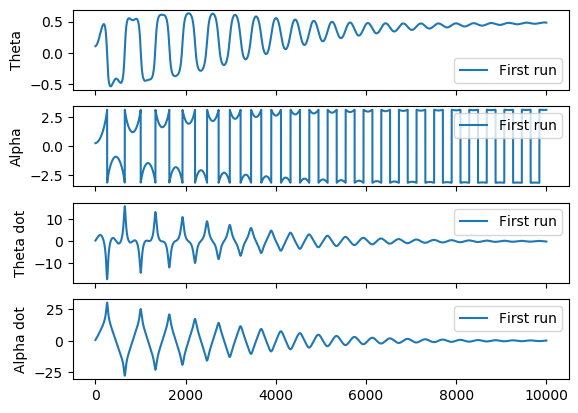

In [31]:
init_state = 0.9 * rand(4)
run_sim(init_state, plot=true)

In [8]:
mutable struct QubeSimulator
    θ::Float
    α::Float
    θ̇::Float
    α̇::Float
    δt::Float
    forward_model::Function
    physparams::PhysicalParameters
    integration_steps::Int
    max_voltage::Float

    # function QubeSimulator(
        # forward_model::Function; 
        # frequency::Float=250, integration_steps::Int=1, max_voltage::Float=18.0)
        # δt = 1.0 / frequency
        # physparams = PhysicalParameters()
        # integration_steps = integration_steps
        # max_voltage = max_voltage
        # θ, α, θ̇, α̇ = [0, 0, 0, 0] + randn(4) * 0.01
        # new(θ, α, θ̇, α̇, δt, forward_model, physparams, integration_steps, max_voltage)
    # end

    function QubeSimulator()
        δt = 1.0 / frequency
        frequency = 250
        max_voltage = 18.0
        integration_steps = 1
        physparams = PhysicalParameters()
        forward_model = forward_model_euler

        θ, α, θ̇, α̇ = [0, 0, 0, 0] + randn(4) * 0.01
        new(θ, α, θ̇, α̇, δt, forward_model, physparams, integration_steps, max_voltage)
    end
end

function step!(sim::QubeSimulator, action::Vector{Float})
    action = clamp.(action, -sim.max_voltage, sim.max_voltage)
    sim.θ, sim.α, sim.θ̇, sim.α̇ = sim.forward_model(
        sim.θ, sim.α, sim.θ̇, sim.α̇, 
        action[1], sim.δt, sim.physparams, sim.integration_steps
    )

    return sim.θ, sim.α, sim.θ̇, sim.α̇
end

function reset_up!(sim::QubeSimulator)
    sim.θ, sim.α, sim.θ̇, sim.α̇ = [0, 0, 0, 0] + randn(4) * 0.01
    return sim.θ, sim.α, sim.θ̇, sim.α̇
end

function reset_down!(sim::QubeSimulator)
    sim.θ, sim.α, sim.θ̇, sim.α̇ = [0, π, 0, 0] + randn(4) * 0.01
    return sim.θ, sim.α, sim.θ̇, sim.α̇
end

reset_down (generic function with 1 method)

In [9]:
q = QubeSimulator()

QubeSimulator(0.004085803367549064, 0.00864944211038992, -0.011877145766857373, 0.0019029167789006104, 0.004, forward_model_euler, PhysicalParameters(8.4, 0.042, 0.042, 0.095, 0.085, 5.719791666666668e-5, 0.00027, 0.024, 0.129, 3.3282000000000004e-5, 5.0e-5, 9.81), 1, 18.0)

In [10]:
function plot_results(hists, labels, colors=Nothing)
    state_dims = ["Theta", "Alpha", "Theta dot", "Alpha dot", "Action"]
    n_axes = length(state_dims)
    
    f, fig_axes = plt.subplots(n_axes, 1, sharex=true)
    for (i, ax) in enumerate(fig_axes)
        if colors == Nothing
            for (hist, label) in zip(hists, labels)
                ax.plot(hist[:,i], label=label)
            end
        else
            for (hist, label, color) in zip(hists, labels, colors)
                ax.plot(hist[:,i], label=label, color=color)
            end
        end
        ax.set_ylabel(state_dims[i])
        ax.legend()
    end
    plt.show()
end

plot_results (generic function with 2 methods)

In [11]:
function simulate(init_state::Vector{Float64}, policy::Function, 
    nsteps::Int, frequency::Float64, integration_steps::Int
)
    qube::QubeSimulator = QubeSimulator()
    
    # Set the initial state of the simulator
    qube.θ, qube.α, qube.θ̇, qube.α̇ = init_state

    s::Vector{Float64} = init_state
    a::Vector{Float64} = policy(s, step=1)
    s_hist::Matrix{Float64} = zeros(nsteps, length(init_state))
    a_hist::Matrix{Float64} = zeros(nsteps, length(a))
    s_hist[1,:] .= s
    a_hist[1,:] .= a

    for i in 2:nsteps
        θ, α, θ̇, α̇ = step!(qube, a)
        s = [θ, α, θ̇, α̇]
        a = policy(s, step=i+1, frequency=frequency)

        s_hist[i,:] .= s # States
        a_hist[i,:] .= a # Actions
    end

    # Return a 2d array, hist[d,n] gives the nth timestep and the dth dimension
    # Dims are ordered as: ['Theta', 'Alpha', 'Theta dot', 'Alpha dot', 'Action']
    return hcat(s_hist, a_hist)
end

simulate (generic function with 1 method)

In [21]:
# Constants between experiments
frequency = 250.0 # in Hz
run_time = 10 # in seconds
nsteps = Int(run_time * frequency)
i_steps = 1

1

In [22]:
# PyPlot.rcParams["figure.figsize"] = (20,20) # make graphs BIG

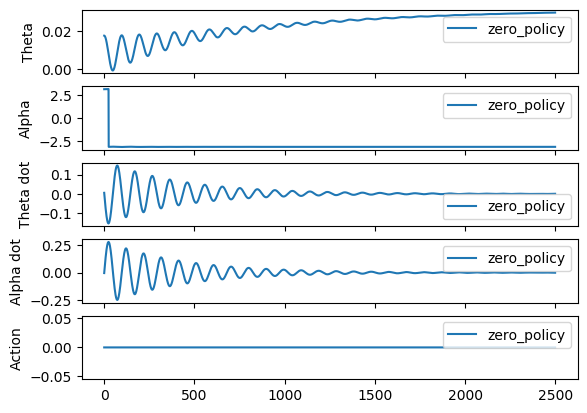

In [23]:
# Natural response when starting at α = 0 + noise (upright/inverted)
init_state = [0, π, 0, 0] + randn(4) * 0.01

hist_zp = simulate(init_state, zero_policy                       , nsteps, frequency, i_steps)
# hist_cp = simulate(init_state, constant_policy                   , nsteps, frequency, i_steps)
# hist_rp = simulate(init_state, random_policy                     , nsteps, frequency, i_steps)
# hist_sw = simulate(init_state, square_wave_policy                , nsteps, frequency, i_steps)
# hist_ec = simulate(init_state, energy_control_policy             , nsteps, frequency, i_steps)
# hist_pd = simulate(init_state, pd_control_policy                 , nsteps, frequency, i_steps)
# hist_fh = simulate(init_state, flip_and_hold_policy              , nsteps, frequency, i_steps)
# hist_sh = simulate(init_state, square_wave_flip_and_hold_policy  , nsteps, frequency, i_steps)
# hist_dd = simulate(init_state, dampen_policy                     , nsteps, frequency, i_steps)
# hist_da = simulate(init_state, dampen_alt_policy                 , nsteps, frequency, i_steps)


# plot_results(hists=[hist_qube], labels=['Hardware'], colors=None)
plot_results(
    [
        hist_zp,
#         hist_cp,
#         hist_rp,
#         hist_sw,
#         hist_ec,
#         hist_pd,
#         hist_fh,
#         hist_sh,
#         hist_dd,
#         hist_da
    ], [
        "zero_policy",
#         "constant_policy",
#         "random_policy",
    #     "square_wave_policy",
#         "energy_control_policy",
#         "pd_control_policy",
#         "flip_and_hold_policy",
#         "square_wave_flip_and_hold_policy",
#         "dampen_policy",
#         "dampen_alt_policy"
    ]
)